In [1]:
import numpy as np
import numpy.lib.recfunctions as recf
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy
import tqdm
import yaml

from data_tools import get_light_gb_injection, mbhb_free_data
from ldc.lisa.noise import AnalyticNoise
from ldc.common.series import XYZ2AET, TDI, FrequencySeries
from ldc.waveform.fastGB import FastGB
from ldc.waveform.lisabeta import FastBHB
from ldc.common.tools import window
from gb_evaluation import GBEval

from lisacattools.catalog import GWCatalogs, GWCatalogType
from lisacattools import HPhist
cmap = plt.get_cmap("tab10")

In [2]:
workdir = "/home/maude/data/LDC/sangria/evaluation"
gb_apc = GBEval('apc-l2it', workdir, submitted_noise=True)
gb_apc.load_from_workspace()

In [3]:
samples_list = list()
for i_sub in tqdm.tqdm((range(len(gb_apc.sub_cat)))):
    pdf = gb_apc.get_pdf(i_sub=i_sub)
    if pdf is not None:
        names = list(pdf.dtype.names).copy()
        names[names.index("EclipticLatitude")] = "Ecliptic Latitude"
        names[names.index("EclipticLongitude")] = "Ecliptic Longitude"
        pdf.dtype.names = names
        pdf = pd.DataFrame(pdf)
        samples_list.append(pdf[["Ecliptic Latitude", "Ecliptic Longitude"]])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5661/5661 [16:27<00:00,  5.73it/s]


In [4]:
all_sources = pd.concat(samples_list)
del samples_list

In [ ]:
nside = 64
hpmap = HPhist(all_sources, nside)
del all_sources

In [ ]:
fig = plt.figure(figsize=(8, 6), dpi=100)
ax = plt.axes([0.05, 0.05, 0.9, 0.9], projection="geo degrees mollweide")
ax.grid()
# use logarithmic scaling for density
ax.imshow_hpx(np.log10(hpmap + 1), cmap="plasma")

In [3]:
def get_raw_data(sangria_fn):
    tdidata = TDI.load(sangria_fn, "obs/tdi")
    attrs = tdidata.X.attrs
    tdidata.X.attrs = attrs; tdidata.Y.attrs = attrs; tdidata.Z.attrs = attrs; 
    tdidata.XYZ2AET()
    tdidata = TDI(dict(zip(tdidata.keys(), 
                           [tdidata[k].ts.fft(win=window, margin=1e6, kap=4.e-6)
                            for k in tdidata.keys()])))
    return tdidata
    
def get_gb_data(sangria_fn):
    tdidata = TDI.load(sangria_fn, "obs/tdi")
    dt = tdidata.X.attrs["dt"]
    T = len(tdidata.t)
    freqs = np.fft.rfftfreq(len(tdidata.t), d=dt)
    A_data = np.zeros(len(freqs), dtype=np.complex128)
    E_data = np.zeros(len(freqs), dtype=np.complex128)
    T_data = np.zeros(len(freqs), dtype=np.complex128)
    for s in gb_apc.sub_cat:
        A,E = gb_apc.get_AE(s, oversample=4)
        kmin = A.attrs['kmin']
        A_data[kmin:kmin+len(A.values)]+= A.values
        E_data[kmin:kmin+len(A.values)]+= E.values
    return TDI(dict(zip(['A', 'E', 'T'],[A_data, E_data, T_data])))
        
def get_mbhb_data(sangria_fn, team, workdir, src=None):
    """ Return MBHB tdi A,E 
    """
    tdidata = TDI.load(sangria_fn, "obs/tdi")
    dt = tdidata.X.attrs["dt"]
    T = len(tdidata.t)*dt
    freqs = np.fft.rfftfreq(len(tdidata.t), d=dt)
    A_data = np.zeros(len(freqs), dtype=np.complex128)
    E_data = np.zeros(len(freqs), dtype=np.complex128)
    T_data = np.zeros(len(freqs), dtype=np.complex128)

    teamdir = os.path.join(workdir, team)
    if team=="apc-l2it":
        mbhb_param = os.path.join(teamdir, 'APC_L2IT-ldc2a-mbhb.yaml')
        L = yaml.load(open(mbhb_param, "r"), yaml.Loader)
        phenomD = FastBHB(approx="IMRPhenomD", T=T, delta_t=dt, bbh_type='mbhb')
        for k in L.keys():
            if k[0:3]=='src':
                param = L[k][0]
                param["Spin1"] = param["ProjectedSpin1"]
                param["Spin2"] = param["ProjectedSpin2"]
                A, E, T = phenomD.get_fd_tdiaet(template=param, freqs=freqs)
                A_data += A.values
                E_data += E.values
                T_data += T.values
    return TDI(dict(zip(['A', 'E', 'T'], [A_data, E_data, T_data])))

In [4]:
sangria_fn = os.path.join(workdir, 'LDC2_sangria_training_v2.h5')
raw_data = get_raw_data(sangria_fn)
mbhb = get_mbhb_data(sangria_fn, 'apc-l2it', workdir)
gb = get_gb_data(sangria_fn)

In [5]:
raw_td = FrequencySeries(raw_data.A.values, fs=raw_data.f.values, name='A').ts.ifft(dt=5)
gb_td = FrequencySeries(gb.A.values, fs=raw_data.f.values, name="A").ts.ifft(dt=5)
mbhb_td = FrequencySeries(mbhb.A.values, fs=raw_data.f.values, name="A").ts.ifft(dt=5)
res = FrequencySeries(raw_data.A.values-gb.A.values-mbhb.A.values, fs=raw_data.f.values, name="A").ts.ifft(dt=5)

In [6]:
dt = 5
f, raw_ =  scipy.signal.welch(raw_td, fs=1.0/dt, window='hanning', nperseg=256*256)
f, mbhb_=  scipy.signal.welch(mbhb_td, fs=1.0/dt, window='hanning', nperseg=256*256)
f, gb_ =  scipy.signal.welch(gb_td, fs=1.0/dt, window='hanning', nperseg=256*256)
f, res_ =  scipy.signal.welch(res, fs=1.0/dt, window='hanning', nperseg=256*256)

Text(0, 0.5, 'TDI |A|')

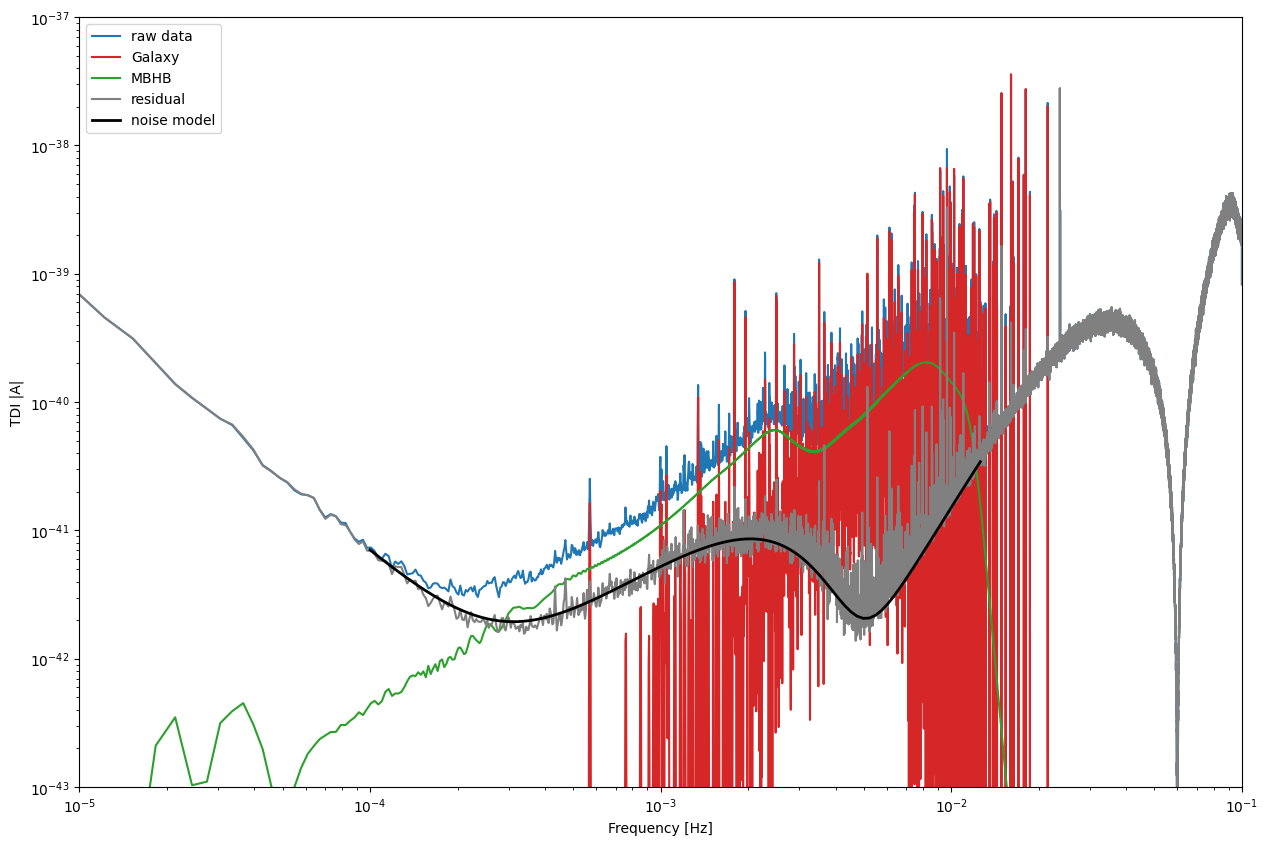

In [31]:
fig, axs = plt.subplots(1,1, figsize=(10,6))
axs.loglog(f, raw_, color=cmap(0), label='raw data')
axs.loglog(f, gb_, color=cmap(3), label='Galaxy')
axs.loglog(f, mbhb_, color=cmap(2), label='MBHB')
axs.loglog(f, res_, label='residual', color='grey')


df = 1/gb_apc.GB.T
frequencies = np.logspace(-4., -1.9, 100)
axs.plot(frequencies, gb_apc.noise(frequencies), label='noise model', color='k', lw=2)

axs.legend(loc="upper left")
axs.set_xlim(1e-5, 1e-1)
axs.set_ylim(1e-43, 1e-37)
axs.set_xlabel("Frequency [Hz]")
axs.set_ylabel("TDI |A|")

In [9]:
mbhb_t = TDI.load(sangria_fn, "sky/mbhb/tdi")
mbhb_t.XYZ2AET()
f, mbhb_psd =  scipy.signal.welch(mbhb_t.A.values, fs=1.0/dt, window='hanning', nperseg=256*256)

gb_t = TDI.load(sangria_fn, "sky/dgb/tdi")
gb_t += TDI.load(sangria_fn, "sky/vgb/tdi")
gb_t += TDI.load(sangria_fn, "sky/igb/tdi")

gb_t.XYZ2AET()
f, gb_psd =  scipy.signal.welch(gb_t.A.values, fs=1.0/dt, window='hanning', nperseg=256*256)

res_t = TDI.load(sangria_fn, "obs/tdi")
res_t.XYZ2AET()
res_t -= mbhb_t
res_t -= gb_t
f, res_psd =  scipy.signal.welch(res_t.A.values, fs=1.0/dt, window='hanning', nperseg=256*256)

Text(0, 0.5, 'TDI |A|')

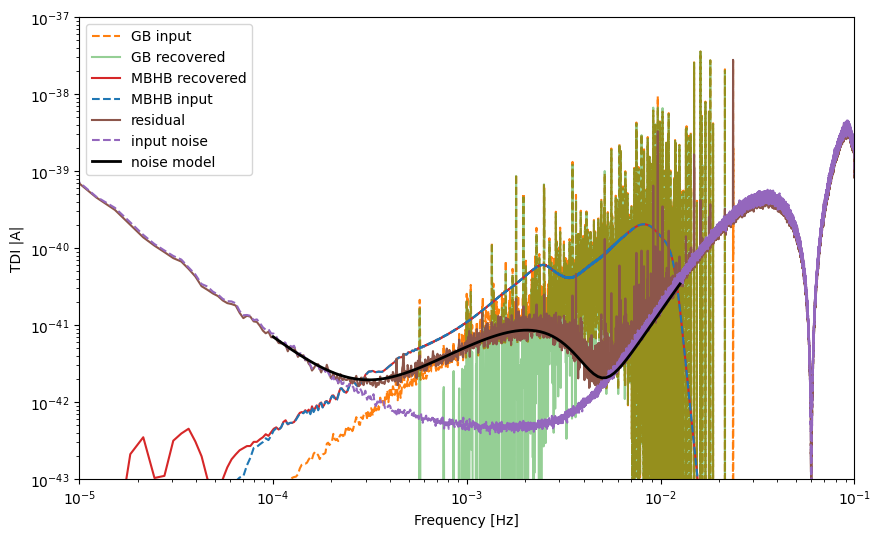

In [16]:
fig, axs = plt.subplots(1,1, figsize=(10,6))
axs.loglog(f, gb_psd, color=cmap(1), label='GB input', ls='--')
axs.loglog(f, gb_, color=cmap(2), label='GB recovered', alpha=0.5)
axs.loglog(f, mbhb_, color=cmap(3), label='MBHB recovered')
axs.loglog(f, mbhb_psd, color=cmap(0), label='MBHB input', ls='--')

axs.loglog(f, res_, label='residual', color=cmap(5))
axs.loglog(f, res_psd, label='input noise', color=cmap(4), ls='--')


df = 1/gb_apc.GB.T
frequencies = np.logspace(-4., -1.9, 100)
axs.plot(frequencies, gb_apc.noise(frequencies), label='noise model', color='k', lw=2)

axs.legend(loc="upper left")
axs.set_xlim(1e-5, 1e-1)
axs.set_ylim(1e-43, 1e-37)
axs.set_xlabel("Frequency [Hz]")
axs.set_ylabel("TDI |A|")

In [17]:
f, res_mbhb = scipy.signal.welch(mbhb_td-mbhb_t.A.values, fs=1.0/dt, window='hanning', nperseg=256*256)
f, res_gb = scipy.signal.welch(gb_td-gb_t.A.values, fs=1.0/dt, window='hanning', nperseg=256*256)

Text(0, 0.5, 'TDI |A|')

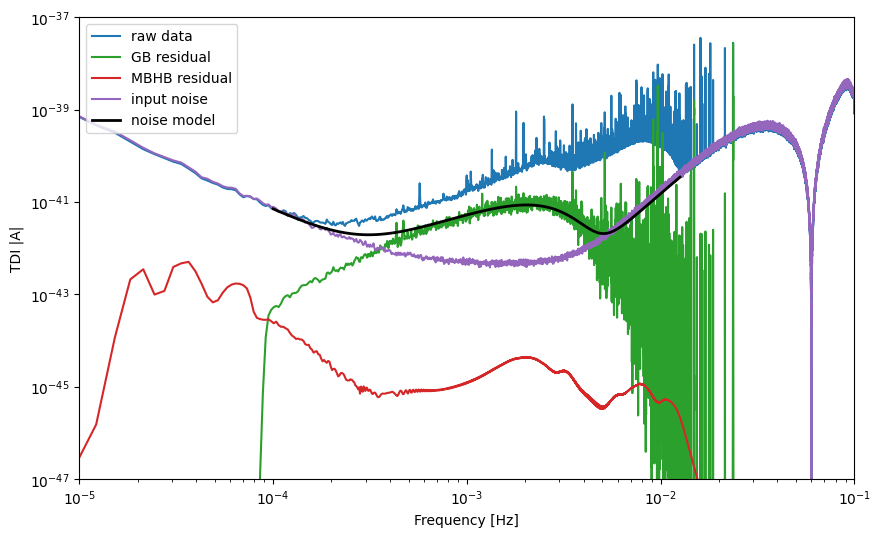

In [21]:
fig, axs = plt.subplots(1,1, figsize=(10,6))
axs.loglog(f, raw_, color=cmap(0), label='raw data')
axs.loglog(f, res_gb, color=cmap(2), label='GB residual')
axs.loglog(f, res_mbhb, color=cmap(3), label='MBHB residual')
#axs.loglog(f, res_, label='residual', color=cmap(5))
axs.loglog(f, res_psd, label='input noise', color=cmap(4))


df = 1/gb_apc.GB.T
frequencies = np.logspace(-4., -1.9, 100)
axs.plot(frequencies, gb_apc.noise(frequencies), label='noise model', color='k', lw=2)

axs.legend(loc="upper left")
axs.set_xlim(1e-5, 1e-1)
axs.set_ylim(1e-47, 1e-37)
axs.set_xlabel("Frequency [Hz]")
axs.set_ylabel("TDI |A|")

Text(0, 0.5, 'TDI |A|')

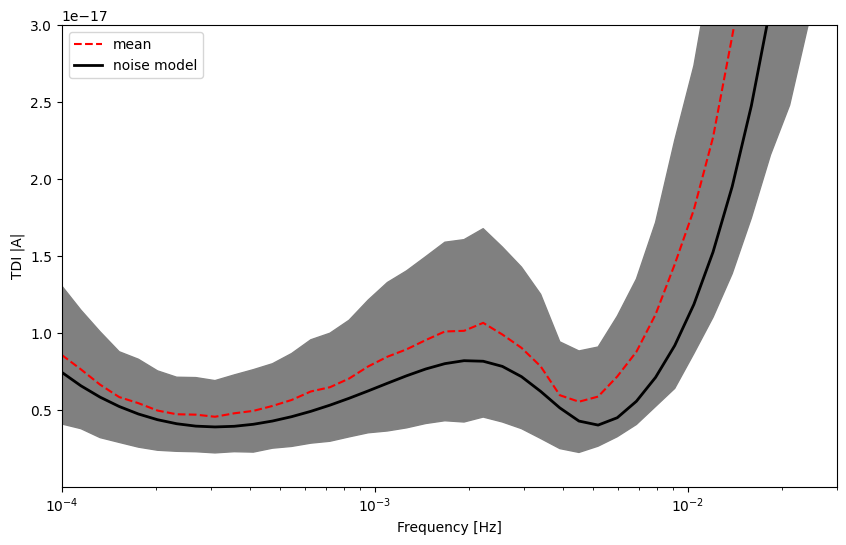

In [6]:
def residual_noise(f, res, frequencies):
    def my_std(x):
        x_ =  x[abs(x - np.median(x)) < 3 * np.std(x)]
        return np.std(x_)
    def my_med(x):
        x_ =  x[abs(x - np.median(x)) < 3 * np.std(x)]
        return np.mean(x_)
    std_ = scipy.stats.binned_statistic(f, np.abs(res), statistic=my_std, bins=frequencies)
    mean_ = scipy.stats.binned_statistic(f, np.abs(res), statistic=my_med, bins=frequencies)
    return mean_[0], std_[0] 

frequencies = np.logspace(-4., -1, 50)
res = raw_data.A.values-gb.A.values-mbhb.A.values
mean, std = residual_noise(raw_data.f.values, res, frequencies)
fig, axs = plt.subplots(1,1, figsize=(10,6))
axs.fill_between(frequencies[:-1], mean-std, y2=mean+std, color='grey')
axs.semilogx(frequencies[:-1], mean, 'r--', label="mean")
axs.plot(frequencies, np.sqrt(gb_apc.noise(frequencies)/(4*df)), label='noise model', color='k', lw=2)

axs.legend(loc="upper left")
axs.set_xlim(1e-4, 3e-2)
axs.set_ylim(1e-20, 3e-17)
axs.set_xlabel("Frequency [Hz]")
axs.set_ylabel("TDI |A|")